# YouTube URL Analysis

## Preface
### Data descriptions

In [1]:
sample_size = 100000000 # specifies the sample size
limit = 15 # specifies the number of elements in lists and graphs

url_columns = ["id","hash","channelId","publishedAt","url","resolvedUrl","domain","resolved","dead","status_code"]
video_columns = ["id","hash","channelId","channelTitle","publishedAt","title","description","tags","categoryId","defaultLanguage","defaultAudioLanguage","duration","dimension","definition","caption","licensedContent","allowedIn","blockedIn","viewCount","likeCount","dislikeCount","favoriteCount","commentCount","requesttime"]
channel_columns = ["id","title","description","subscriberCount","videoCount","commentCount","viewCount","featuring","subscribing","country","publishedAt","daysactive","keywords","topics","wikitopics"]

### Import necessary modules

In [2]:


import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(14,8.27)})

### Load sample

In [3]:
# load and clean csv
pd_url_data = pd.read_csv('sample_' + str(sample_size) + '.csv')
pd_url_data.columns = url_columns

# add year column, based on publishedAt
pd_url_data['year'] = pd.to_datetime(pd_url_data["publishedAt"]).dt.year

#todo handling missing data (e.g. resolvedURL not set, but not a shortener)

### clean domains

In [4]:
# remove all www. or www2.
pd_url_data.replace({'domain': r'^www2?\.'}, {'domain': ''}, regex=True, inplace=True) 

# replace all open.spotify.com by spotify.com
pd_url_data.replace({'domain': r'^open\.spotify'}, {'domain': 'spotify'}, regex=True, inplace=True) 

# todo: check domains and see whether more needs to be replaced

# Generic analysis

## Dead or alive (status codes)
When less than 5%, just leave it as is



In [5]:
# add count column
pd_url_data['count'] = 1 
# count URLs marked as dead on expansion and sort in reverse
pd_url_data_groupedDead = pd_url_data.groupby(["dead"]).count()['count'].sort_values(ascending=False) 
# count total number of URLs
total = pd_url_data_groupedDead[0] + pd_url_data_groupedDead[1] 
# calculate percentage
percent_dead = round(pd_url_data_groupedDead[1]/total*100,2) 
# print percentage
print("Total URLS: %s, of which %s (%s%%) dead" % (total,pd_url_data_groupedDead[1],percent_dead)) 

Total URLS: 99999999, of which 3523726 (3.52%) dead


## Basic stats (based on videos, not channels)
### Top domains

In [6]:
# reset count column
pd_url_data['count'] = 1 
# count domains in URLs data set and sort in reverse
pd_url_data_groupedDomain = pd_url_data.groupby(["domain"]).count()['count'].sort_values(ascending=False) 
# print header
print("Top %s domains" % (limit)) 
# print most used domains overall
print(pd_url_data_groupedDomain.head(limit)) 

Top 15 domains
domain
youtube.com            31876575
facebook.com           11423656
twitter.com             9155160
instagram.com           5417585
google.com              2093695
twitch.tv                985928
vk.com                   943318
play.google.com          540668
soundcloud.com           540583
amazon.com               484304
accounts.google.com      442254
itunes.apple.com         427923
pinterest.com            413897
patreon.com              377092
amazon.de                276274
Name: count, dtype: int64


### Top deep links

In [7]:
# reset count column
pd_url_data['count'] = 1 
# count resolved deep links in URLs data set and sort in reverse
pd_url_data_groupedUrl = pd_url_data.groupby(["resolvedUrl"]).count()['count'].sort_values(ascending=False) 
# print header
print("Top %s resolvedUrl" % (limit)) 
# print most used deep links
print(pd_url_data_groupedUrl.head(limit)) 

Top 15 resolvedUrl
resolvedUrl
https://unacademy.com/unavailable                        84866
https://www.youtube.com/error?src=404                    82125
https://www.youtube.com/user/euronewsnetwork/channels    73532
https://www.facebook.com/euronews                        68619
http://incompetech.com/                                  63469
https://www.zee5.com/                                    60956
https://creativecommons.org/licenses/by/4.0/)            59933
https://www.zee5.com                                     55108
https://www.youtube.com/playlist?list...                 54848
https://www.instagram.com/zee5                           53211
https://twitter.com/ZEE5India                            52535
https://www.facebook.com/ZEE5/                           52173
http://creativecommons.org/licenses/by/3.0/              47656
https://datinglogic.net/forums/forum/qa/                 45255
https://onlinedatinglogic.com/forums/forum/qa/           45187
Name: count, dtype: int6

### Top TLDs

In [8]:
# reset count column
pd_url_data['count'] = 1 
# make TLD column based on domain
pd_url_data['tld'] = pd_url_data['domain'].str.replace('^.*\.', '', regex=True) 
# count TLDs used and sort in reverse
pd_url_data_groupedTld = pd_url_data.groupby(["tld"]).count()['count'].sort_values(ascending=False)
# print header
print("Top %s TLDs" % (limit))
# print most used TLDs
print(pd_url_data_groupedTld.head(limit))

Top 15 TLDs
tld
com    75218345
tv      1693006
net      658282
in       499408
de       493090
org      484137
me       403245
ru       373593
br       298229
kr       295295
gg       278747
co       234860
jp       213021
st       193963
uk       169487
Name: count, dtype: int64


# Monetization

## Allowed merch and monetization on Github (by Bernhard)

In [9]:
# import merch and crowd lists
from allowed_3rdparty import merch, crowd

# drop previously added count column
if 'count' in pd_url_data.columns:
    pd_url_data = pd_url_data.drop(['count'],axis=1)

# add boolean column to pd_url_data based on presence in lists
pd_url_data["crowd"] = np.where(pd_url_data["domain"].isin(crowd), True, False)
pd_url_data["merch"] = np.where(pd_url_data["domain"].isin(merch), True, False)

## Percentage of videos that have at least one merchandise or one crowd-funding link.

In [11]:
# make a column where at least one of monetized or crowd is true
monetized = pd_url_data['merch'] | pd_url_data['crowd'] 
pd_url_data['monetized'] = monetized
# get number of video ids where monetized = True
monetized_video_number = len(pd_url_data[pd_url_data['monetized']==True])
total_video_number = len(pd_url_data['monetized'])
percent_video_monetized = round(monetized_video_number/total_video_number*100,2)

print("%s videos are monetized out of %s total videos, that is %s%%" % (monetized_video_number,total_video_number,percent_video_monetized))

2027345 videos are monetized out of 99999999 total videos, that is 2.03%


## Number of YouTube videos per domain, per monetization type. As well as graph of domains per year, per monetization type


crowd domain count
domain
patreon.com            377092
streamlabs.com         115697
apoia.se                16419
gofundme.com            12904
tipeee.com               8806
patronite.pl             6839
kickstarter.com          3929
change.org               3592
indiegogo.com            2870
vakinha.com.br           1557
catarse.me               1202
justgiving.com            778
forhumanpeoples.com       602
milaap.org                517
camp-fire.jp              357
Name: count, dtype: int64


crowd domain stats
count        66.000000
mean       8406.212121
std       48281.659680
min           1.000000
25%           4.000000
50%          17.500000
75%         157.500000
max      377092.000000
Name: count, dtype: float64


merch domain count
domain
soundcloud.com            540583
itunes.apple.com          427923
teespring.com              92772
spreadshirt.com            90044
store.steampowered.com     66381
bandcamp.com               51167
etsy.com                   20626
store.

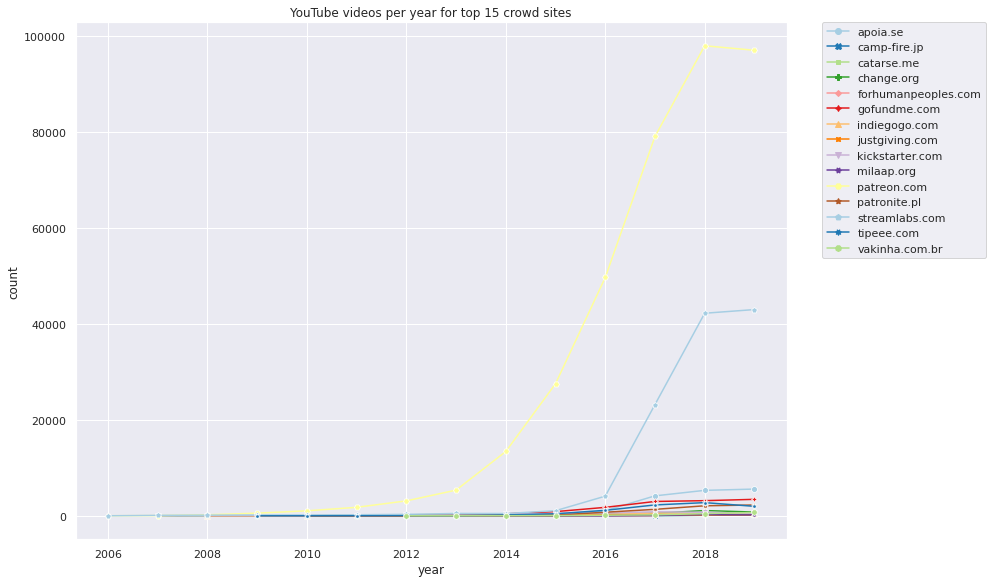

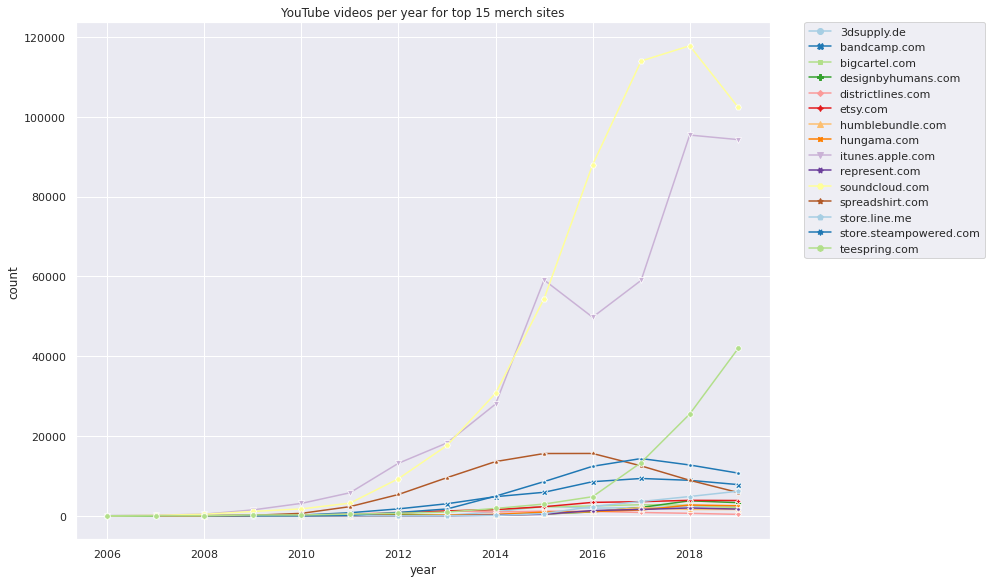

In [10]:
for type in ['crowd','merch']:

    ''' Count and describe '''

    # reset count column to 1
    pd_url_data['count'] = 1
    # filter pd_url_data to only retain info for rows with merch domain
    filtered = {}
    filtered[type] = pd_url_data[pd_url_data[type]==True]
    # count type domains in data set and sort in reverse
    filtered_count = {}
    filtered_count[type] = filtered[type].groupby(["domain"]).count()['count'].sort_values(ascending=False)
    # print header
    print("%s domain count" % type)
    # print most used merch domains
    print(filtered_count[type].head(limit))
    print("\n")
    # print merch domain stats
    print("%s domain stats" % type)
    print(filtered_count[type].describe())
    print("\n")

    ''' Graph '''

    # limit data by top overall merch domain for graph
    top_domains = {}
    top_domains[type] = filtered_count[type].keys().to_series().head(limit)
    filtered_limited = {}
    filtered_limited[type] = filtered[type][filtered[type]['domain'].isin(top_domains[type])==True]

    # get number of unique domains for color palette in graph 
    num_domains = {}
    num_domains[type] = len(filtered_limited[type]['domain'].unique())
    color_palette = {}
    color_palette[type] = sns.color_palette("Paired",n_colors=num_domains[type])

    # count by merch domain and year
    filtered_limited_count = {}
    filtered_limited_count[type] = filtered_limited[type].groupby(["domain","year"]).count()

    # plot rise of crowd sites, per year
    plt.figure()
    sns.lineplot(x="year", y="count", hue="domain", style="domain", palette = color_palette[type], markers=True, dashes=False, data=filtered_limited_count[type])
    plt.title("YouTube videos per year for top %s %s sites" % (limit,type))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()


## Todo

Channel data set
* Fuse this with channels data set. Finding a way to use the URLs to characterize channels.
   * Merch and monetization per channel. When did they introduce this?
   * Whether channels changed merch or crowd-financing, giving that they not backport.
* Via topic and/or video categories. E.g. gaming may have a very different URL profile then news/politics. 
* Merch stores with particular topical affinity (e.g. alt-right channels use store X) - alternative ways of classifying youtube. Otherway around: categories that are more suited to crowd-funding than others.

Alternative modes of classification? 
* For a channel we have channel description, keywords, all video titles and keywords. Run as a topic model.
* Video categories are unique and chosen by uploaders
* Channel category column can have several channels, is assigned done automatically by YouTube
* (channels have keywords too, which are much more descriptive. But long-tail, language specific)


Other
* Patreon pledgers, crowd-funding sites/pledges.
* Collect ASINs. How many different products are being advertised (most popular producst - # videos, #views; youtube as amazon catalogue).
* Each URL may afford something for analysis.
* Cross-language analysis. (Videos have language, channels have country flag). 

# Random

In [12]:
# domains used per channelId
pd_url_data['count'] = 1
pd_url_data_grouped = pd_url_data.groupby(["channelId","domain"]).count()['count'].sort_values(ascending=False)
pd_url_data_grouped.head()

channelId                 domain     
UC_IEcnNeHc_bwd92Ber-lew  youtube.com    255623
UC1pHFqCMAIHP8gr4lYGtNLA  youtube.com    205114
UCP0uG-mcMImgKnJz-VjJZmQ  youtube.com    190357
UCIme7og-uTpdRXRgm0zzA2A  youtube.com    174172
UCFjzJYgxHjk44AFoEwwgPjg  youtube.com    173895
Name: count, dtype: int64